In [1]:
import pysiaf
from skimage.transform import ProjectiveTransform, warp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import asdf
import os
from astropy.io import fits

mpl.rcParams["image.interpolation"] = "nearest"
mpl.rcParams["image.origin"] = "lower"
mpl.rcParams["figure.figsize"] = [10, 10]
mpl.rcParams["image.cmap"] = "hot"

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-068 DOESN'T MATCH THE CURRENT ONLINE VERSION PRDOPSSOC-072
Please consider updating pysiaf, e.g. pip install --upgrade pysiaf or conda update pysiaf


In [2]:
fdir = "/global/cfs/cdirs/m4943/grismsim/20260216_01"
sca = range(1, 19)
fns = [[ii, f"grism_ra10_dec0_pa60_detSCA{ii:02}_l2.asdf"] for ii in sca]
fits_fns = [[ii, f"grism_ra10_dec0_pa60_detSCA{ii:02}.fits"] for ii in sca]

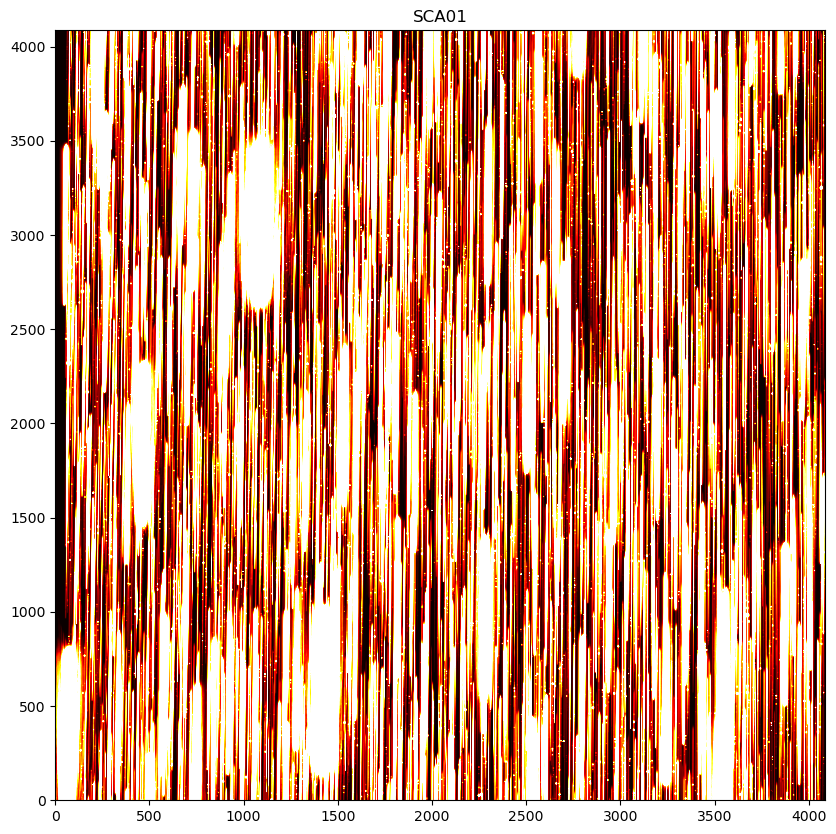

In [3]:
det_idx = 0
file = fits.open(os.path.join(fdir, fits_fns[det_idx][1]))
plt.imshow(file["MODEL"].data, vmin=0, vmax=0.01)
plt.title(f"SCA{fns[det_idx][0]:02}")
# plt.savefig("SCA01.png")
plt.show()
file.close()

-55365.59
2110.6147


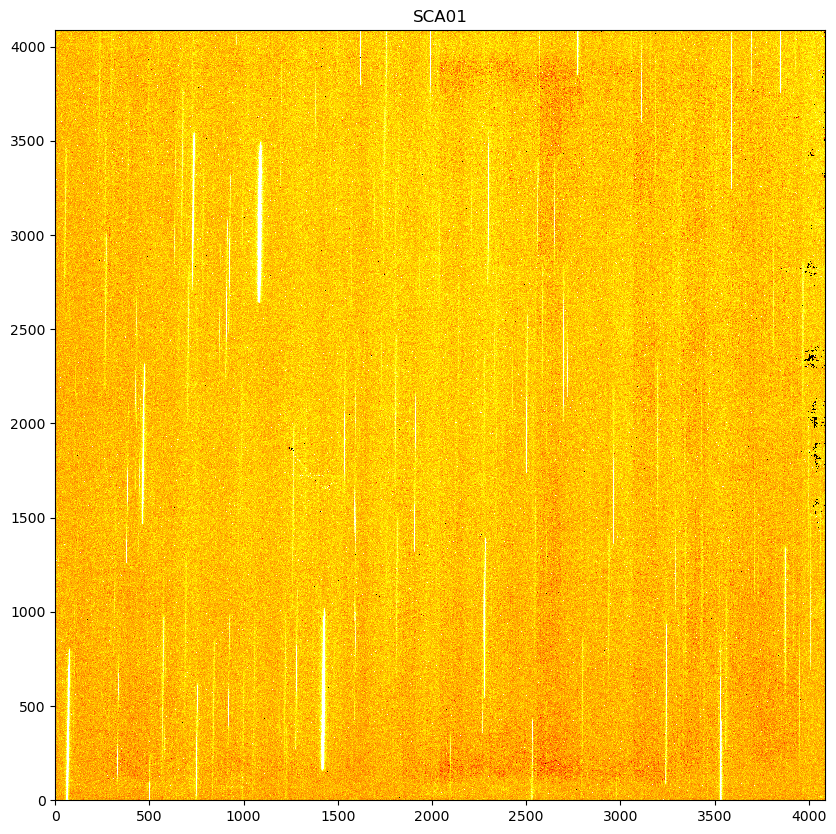

In [4]:
det_idx = 0
file = asdf.open(os.path.join(fdir, fns[det_idx][1]))
plt.imshow(file["roman"]["data"], vmin=0, vmax=3)
plt.title(f"SCA{fns[det_idx][0]:02}")
# plt.savefig("SCA01.png")
print(np.min(file["roman"]["data"]))
print(np.max(file["roman"]["data"]))
plt.show()
file.close()

In [5]:
models = []
for ii, fn in enumerate(np.sort(fns)):
    file = asdf.open(os.path.join(fdir, fn[1]))
    models.append([ii+1, np.asarray(file["roman"]["data"])])
    # plt.imshow(file[4].data, vmin=0, vmax=50)
    # plt.title(f"SCA{fn[0]:02}")
    # plt.show()
    file.close()

In [6]:
siaf = pysiaf.Siaf("roman")
v2, v3 = siaf.apertures["WFI_CEN"].V2Ref, siaf.apertures["WFI_CEN"].V3Ref

def sky_model(model, det_num, ra, dec, pa):
    aper = siaf.apertures[f"WFI{det_num:02}_FULL"]
    attmat = pysiaf.utils.rotations.attitude_matrix(v2, v3, ra, dec, pa)

    aper.set_attitude_matrix(attmat)
    verts = aper.idl_to_sky([aper.XIdlVert1, aper.XIdlVert2, aper.XIdlVert3, aper.XIdlVert4], 
                            [aper.YIdlVert1, aper.YIdlVert2, aper.YIdlVert3, aper.YIdlVert4])
    
    ny, nx = model.shape
    src = np.array([
        [0, 0],
        [nx, 0],
        [nx, ny],
        [0, ny]
    ])

    # Destination corners (in sky coordinates)
    dst = np.array([
        [verts[0][0], verts[1][0]],  # 1
        [verts[0][3], verts[1][3]],  # 2
        [verts[0][2], verts[1][2]],  # 3
        [verts[0][1], verts[1][1]],  # 4
    ])

    # Projective transform
    tform = ProjectiveTransform()
    tform.estimate(src, dst)

    # Create a grid in sky coordinates covering the detector
    ra_min, ra_max = dst[:,0].min(), dst[:,0].max()
    dec_min, dec_max = dst[:,1].min(), dst[:,1].max()
    ra_grid, dec_grid = np.meshgrid(
        np.linspace(ra_min, ra_max, nx),
        np.linspace(dec_min, dec_max, ny)
    )
    coords = np.stack([ra_grid.ravel(), dec_grid.ravel()]).T
    pix_coords = tform.inverse(coords).T
    pix_coords = pix_coords.reshape(2, ny, nx)

    # Warp the image
    warped = warp(model, np.array([pix_coords[1], pix_coords[0]]), output_shape=(ny, nx))

    return (warped, [ra_min, ra_max, dec_min, dec_max])

In [7]:
on_sky = []
for ii, model in models:
    on_sky.append(sky_model(model, ii, 10, 0, 60))

/tmp/ipykernel_1210975/1259739388.py:6: RuntimeWarning: invalid value encountered in log
  ax.imshow(np.log(warped+1), extent=extent, vmin=0.5, vmax=3)


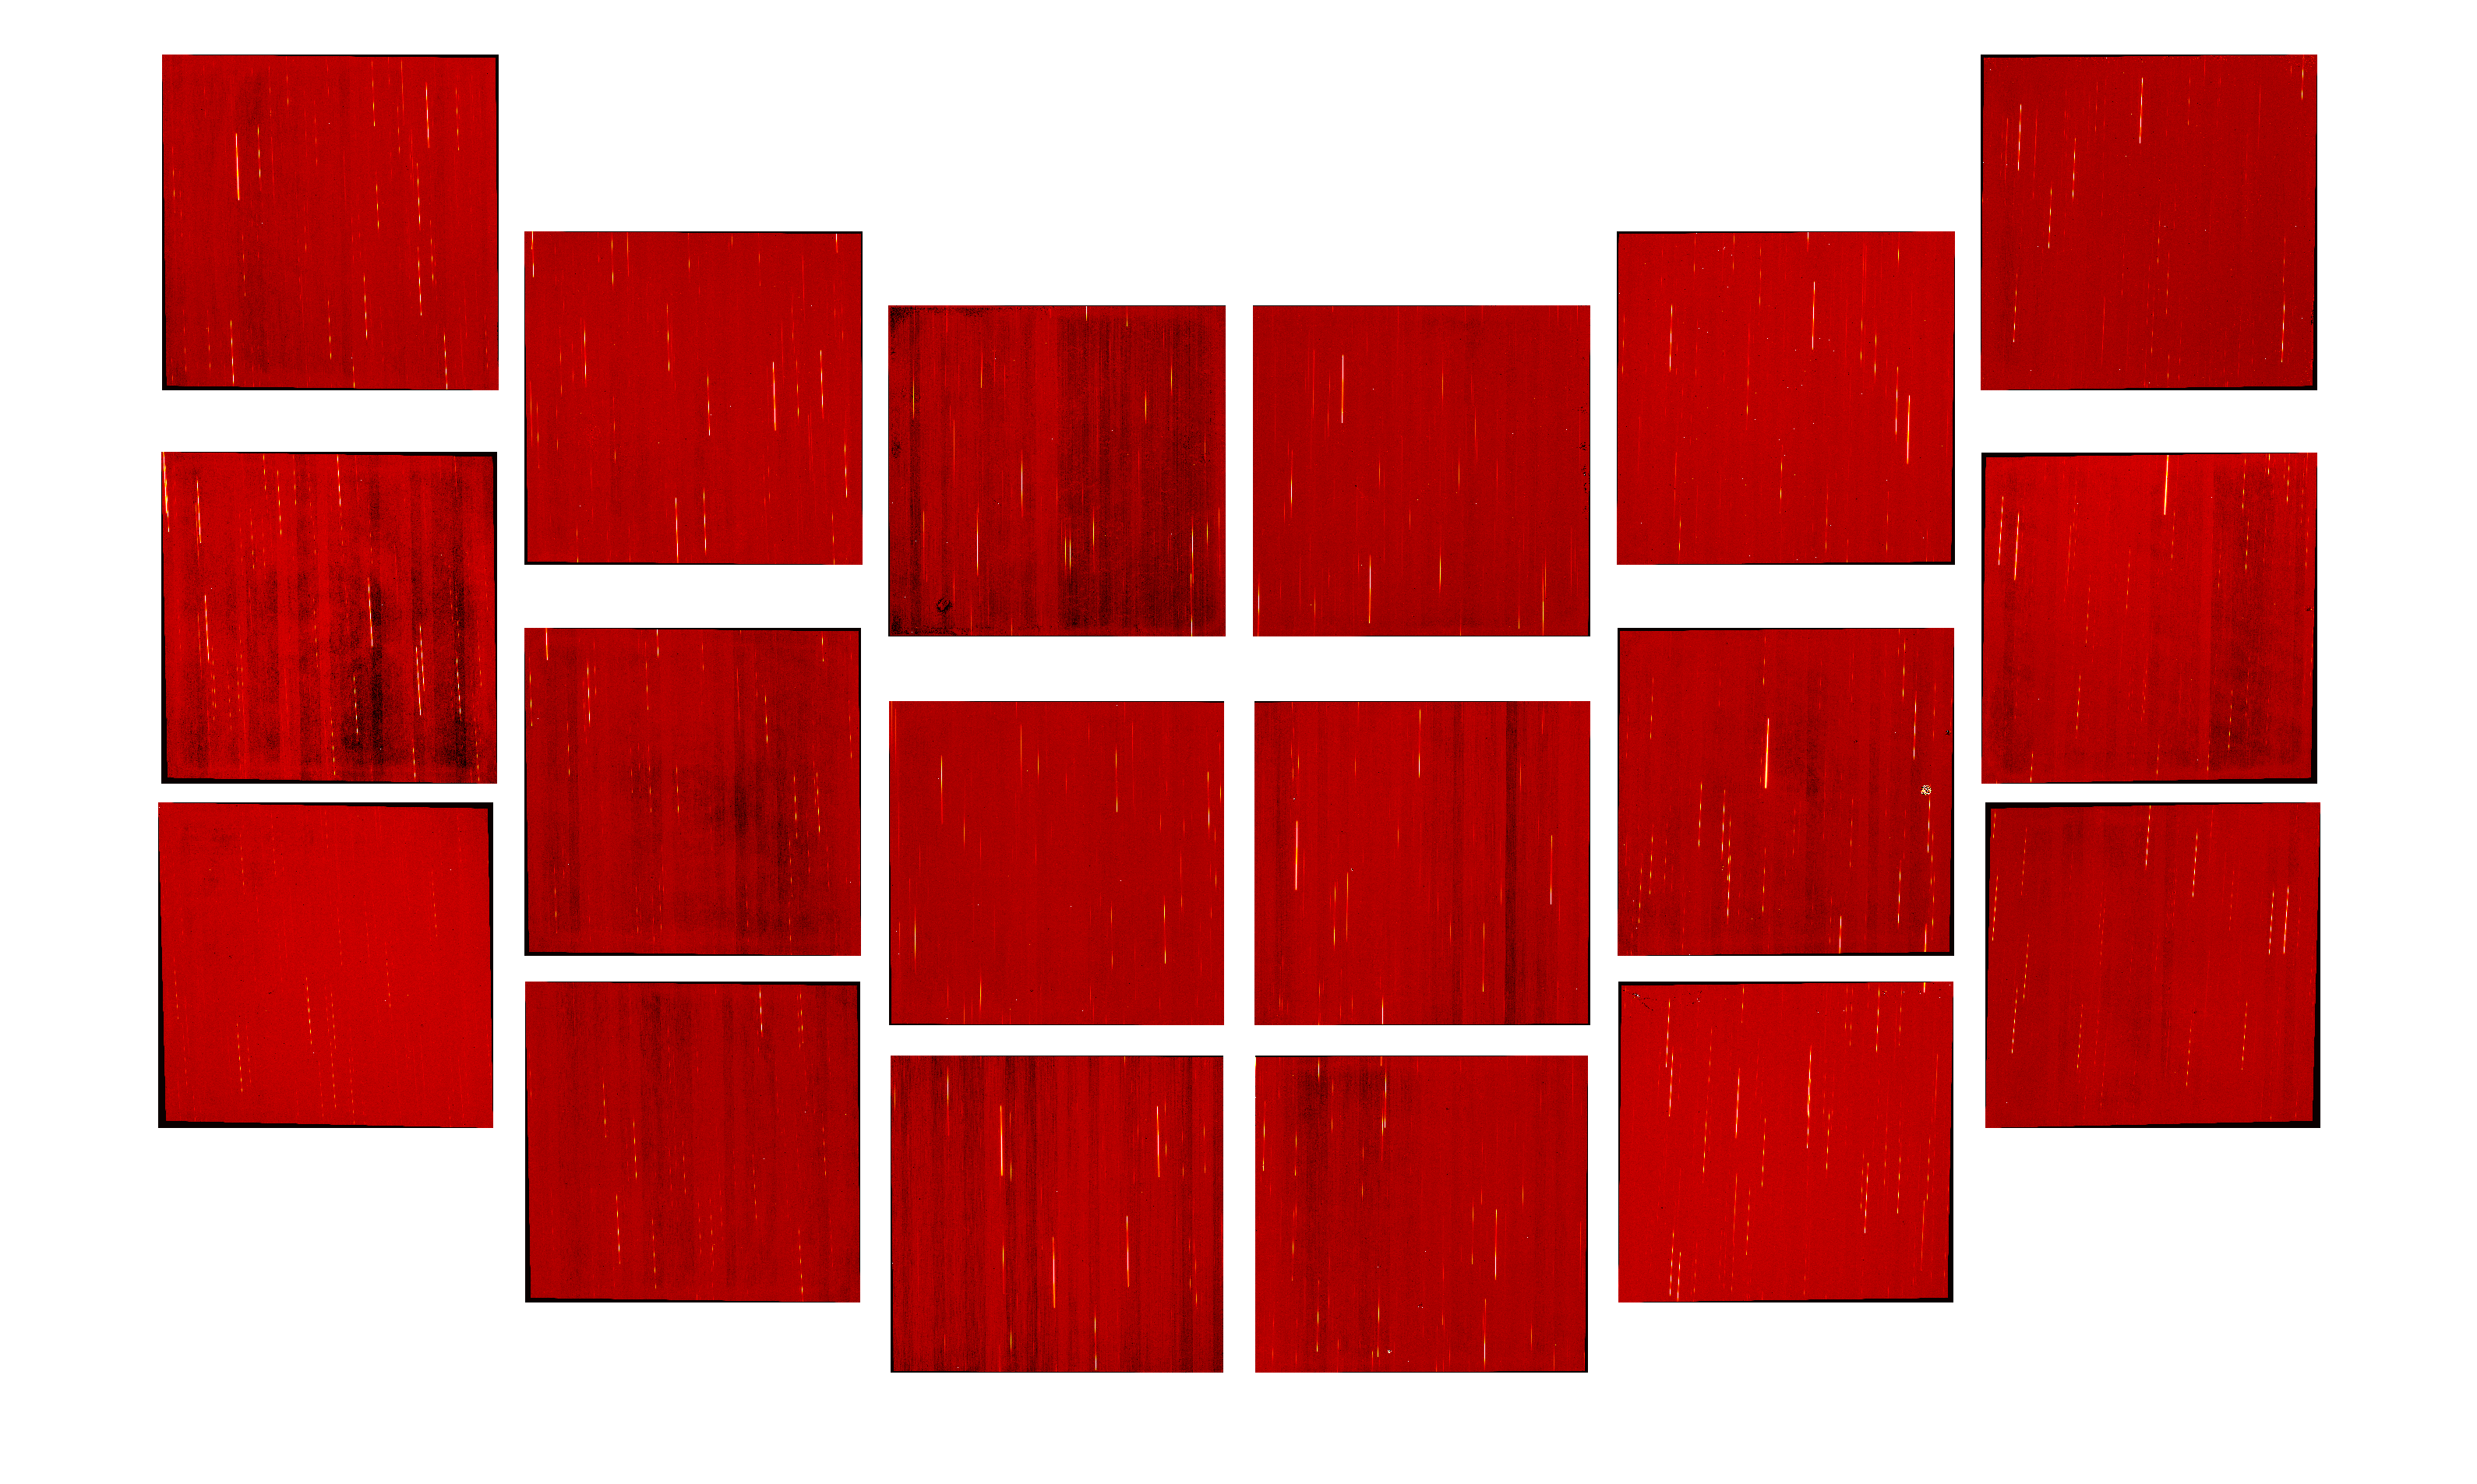

In [9]:
mpl.rcParams["figure.dpi"] = 400
fig, ax = plt.subplots()
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
for warped, extent in on_sky:
    ax.imshow(np.log(warped+1), extent=extent, vmin=0.5, vmax=3)

ax.set_xlim([10.45, 9.55])
ax.set_ylim([-0.33, 0.2])
ax.axis("off");

fig.savefig("romanisim_on_sky.png", transparent=True)